# Data Science Capstone
This notebook will be mainly used for the capstone project.

## Import libraries

In [1]:
import numpy as np

import pandas as pd

from itertools import chain 

import json

import io

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

In [3]:
# @hidden_cell
CLIENT_ID = "S0N1Q51LLQJU3PBFLDSQHBV2IXDOPL3NTGEUTK02CZ013YKP"
CLIENT_SECRET = "O0H5N2BDLKS3QDO0KQDOBMNI1WFMA4TNTMU4WVHXKW5DO1PA"
VERSION = "20200707"
LIMIT = 50
foursquare_api_str = "https://api.foursquare.com/v2/%s/%s?client_id={}&client_secret={}&v={}".format(
    CLIENT_ID, CLIENT_SECRET, VERSION
)

## Import Toroto neighbourhood data

Import data from Wikipadia, the dataframe will consist of three columns: PostalCode, Borough, and Neighborhood. Add the geographic data.

**Data Cleansing**

Only the datapoints with a no "Not assigned" borough will be cosindered during the analysis. If a datapoint has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.

In [4]:
# neighbourhood data
df_neighborhood = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)[0]
df_neighborhood = df_neighborhood[df_neighborhood['Borough'] != 'Not assigned']
not_neighborhood_idx = df_neighborhood['Neighborhood'] == 'Not assigned'
df_neighborhood['Neighborhood'][not_neighborhood_idx] = df_neighborhood['Borough'][not_neighborhood_idx]
print('df_neighborhood.shape: ', df_neighborhood.shape)
print(df_neighborhood.head())

# geographic data
geo_url = requests.get('https://cocl.us/Geospatial_data').text
df_lat_long = pd.read_csv(io.StringIO(geo_url))

# merge neighbourhood data and geographic data
df_toronto = pd.merge(df_neighborhood, df_lat_long, on='Postal Code')
print('df_toronto.shape: ', df_toronto.shape)
print(df_toronto.head())

df_neighborhood.shape:  (103, 3)
  Postal Code           Borough                                 Neighborhood
2         M3A        North York                                    Parkwoods
3         M4A        North York                             Victoria Village
4         M5A  Downtown Toronto                    Regent Park, Harbourfront
5         M6A        North York             Lawrence Manor, Lawrence Heights
6         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government
df_toronto.shape:  (103, 5)
  Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government 

## Explore Toronto

Top Toronto neighborhood by number of avenues.

In [44]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [35]:
toronto_venue_counts = toronto_venues.groupby('Neighborhood').count()
print(toronto_venue_counts.head())

                                                 Neighborhood Latitude  \
Neighborhood                                                             
Agincourt                                                            4   
Alderwood, Long Branch                                               8   
Bathurst Manor, Wilson Heights, Downsview North                     20   
Bayview Village                                                      4   
Bedford Park, Lawrence Manor East                                   24   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
Agincourt                                                             4   
Alderwood, Long Branch                                                8   
Bathurst Manor, Wilson Heights, Downsview North                      20   
Bayview Village                                                       4   
Bedford Park, Lawrence Manor Ea

In [38]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.head())

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

   Yoga Studio  Accessories Store  Airport  Airport Food Court  \
0            0                  0        0                   0   
1            0                  0        0                   0   
2            0                  0        0                   0   
3            0                  0        0                   0   
4            0                  0        0                   0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium      ...        Train Station  \
0             0         0      ...                    0   
1             0       

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Skating Rink,Latin American Restaurant,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,"Alderwood, Long Branch",Pizza Place,Gym,Pharmacy,Coffee Shop,Athletics & Sports,Pub,Sandwich Place,Distribution Center,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Ice Cream Shop,Bridal Shop,Sandwich Place,Diner,Restaurant,Deli / Bodega,Supermarket,Middle Eastern Restaurant
3,Bayview Village,Japanese Restaurant,Café,Bank,Chinese Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Sushi Restaurant,Thai Restaurant,Pharmacy,Pizza Place,Pub,Café


## K-means and mapping

In [41]:
kclusters = 5
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df_toronto
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,4.0,Food & Drink Shop,Park,Bus Stop,Women's Store,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Portuguese Restaurant,Pizza Place,Coffee Shop,Hockey Arena,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Park,Bakery,Breakfast Spot,Café,Pub,Theater,Cosmetics Shop,Shoe Store,Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Accessories Store,Event Space,Vietnamese Restaurant,Boutique,Miscellaneous Shop,Coffee Shop,Doner Restaurant,Diner
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Diner,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café,College Auditorium


In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    if not np.isnan(cluster):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

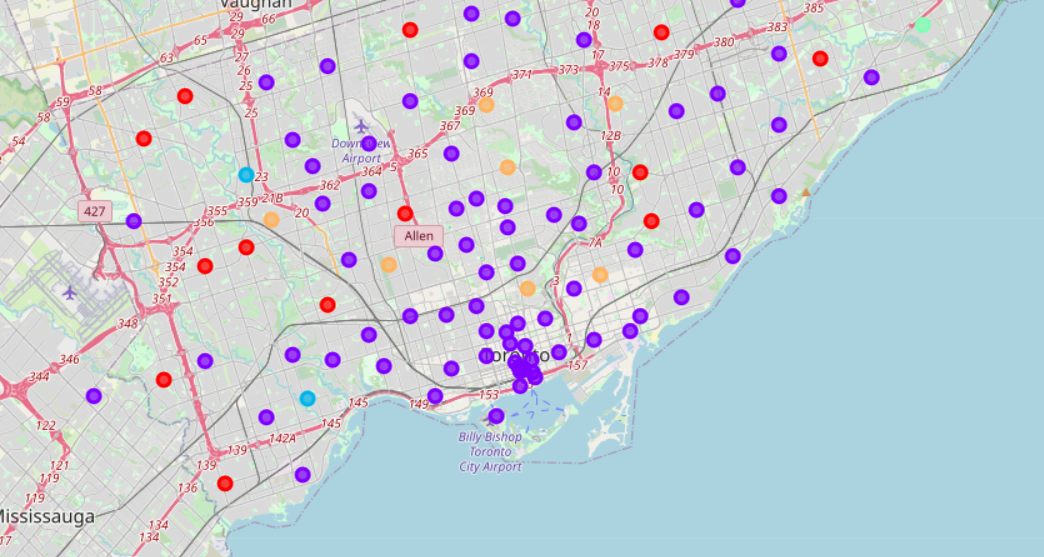